In [1]:
cd ..

/home/tommy/Scrivania/Polimi/Honours Programme/SCFR


In [2]:
from os import listdir, path
import json
import matplotlib.pyplot as plt

from data_structures.cfr_trees import CFRTree
from games.goofspiel import build_goofspiel_tree
from games.kuhn import build_kuhn_tree
from games.leduc import build_leduc_tree
from functools import reduce

In [3]:
def parameters_to_string(par):
    if(par['game'] == 'kuhn'):
        return 'kuhn_' + str(par['players']) + '_' + str(par['rank'])
    if(par['game'] == 'leduc'):
        return 'leduc_' + str(par['players']) + '_' + str(par['suits']) + '_' + str(par['rank'])
    if(par['game'] == 'goofspiel'):
        return 'goofspiel_' + str(par['players']) + '_' + str(par['rank']) + '_' + str(par['tie_solver'])
    if(par['game'] == 'random'):
        return 'random_' + str(par['players']) + '_' + str(par['depth']) + '_' + str(par['branching_factor'])

In [4]:
# TODO: check it, in particular for bigger versions of goofspiel
# TODO: implement different goofspiel TieSolver

def delta_utility(game, players, rank, betting_parameters = [2, 4]):
    if game == 'kuhn':
        return 2 * players
    if game == 'leduc':
        return players + players * betting_parameters[0] + players * betting_parameters[1]
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return 1

In [5]:
def max_social_welfare(game, players, rank, betting_parameters = [2, 4]):
    if game == 'kuhn' or game == 'leduc':
        return 0
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))
    if game == 'random':
        return players

In [10]:
target_directory = "results/remote/RCFR/kuhn/"

In [11]:
file_names = listdir(target_directory)

In [12]:
def analyze(name, target_epsilons, data_per_instance):
    if path.isdir(target_directory + name):
        return
    
    file = open(target_directory + name, "r")
    data = json.load(file)
    
    print("File = " + name)
    print("Game = " + parameters_to_string(data['parameters']))
    
    print("Total iterations = " + str(data['parameters']['number_iterations']))
    print("Check every iteration = " + str(data['parameters']['check_every_iteration']))
    
    # --------- SKIP 2 PLAYERS LEDUC AND GOOFSPIEL ---------
    if data['parameters']['game'] in ['goofspiel', 'leduc'] and data['parameters']['players'] == 2:
        print("---------------------------")
        print("Skipping 2 player versions")
        print("---------------------------")
        print("")
        return
    # ------------------------------------------------------
    
    durations = list(map(lambda el: el['duration'], data['data']))
    
    target_datapoint_amount = int(data['parameters']['number_iterations']) / int(data['parameters']['check_every_iteration'])
    run_time = sum(durations)
    avg_time = run_time / len(durations)
    print("Logged " + str(len(data['data'])) + " out of " + str(target_datapoint_amount) + " datapoints in " + \
          str(run_time) + " seconds (aka " + str(run_time/3600) + " hours)")
    print("Average duration of batch = " + str(avg_time) + " seconds (aka " + str(avg_time/3600) + " hours)")

    if 'total_duration' in data:
        running_time = data['total_duration']
        print("Solved in " + str(running_time) + " seconds")
        print("Solved in " + str(running_time / 60) + " minutes")
        print("Solved in " + str(running_time / 3600) + " hours")
        
    if 'utility' in data:
        u = data['utility']
        sw = sum(u)
        print("Final utility = " + str(u))
        print("Social welfare = " + str(sw))
        max_sw = max_social_welfare(data['parameters']['game'], data['parameters']['players'], 
                                    data['parameters']['rank'], data['parameters']['betting_parameters'])
        if max_sw != 0:
            print("Max social welfare = " + str(max_sw) + " (obtained " + \
                  str(sw / max_sw * 100) + "%)")

    if 'total_duration' in data:
        print("Average iterations per second = " + str(data['average_iterations_per_second']))
    
    du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'])

    iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
    epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
    percent_epsilons = list(map(lambda el: el / du, epsilons))
    #absolute_joint_sizes = list(map(lambda el: el['absolute_joint_size'], data['data']))
    #relative_joint_sizes = list(map(lambda el: el['relative_joint_size'], data['data']))
    #max_plan_frequencies = list(map(lambda el: el['max_plan_frequency'], data['data']))
    #joint_support_sizes = list(map(lambda el: el['joint_support_size'], data['data']))
    
    plt.plot(iteration_counts, epsilons)
    plt.show()
    plt.plot(iteration_counts, percent_epsilons)
    plt.show()
    
    time_to_target = []
    iterations_to_target = []
    
    for t in target_epsilons:
        indices_below_t = [i for i in range(len(epsilons)) if percent_epsilons[i] <= t]
        if len(indices_below_t) > 0:
            time_to_t = sum(durations[:indices_below_t[0]+1])
            iterations_to_target.append((indices_below_t[0]+1) * int(data['parameters']['check_every_iteration']))
        else:
            time_to_t = -1
            iterations_to_target.append(-1)
        time_to_target.append(round(time_to_t, 5))
    
    s = parameters_to_string(data['parameters'])
    while s in data_per_instance:
        s += '_'
    data_per_instance[s] = {'time_to_target': time_to_target,
                            'iterations_to_target': iterations_to_target,
                            'parameters': data['parameters']}

File = 1553957877_3_9
Game = kuhn_3_9
Total iterations = 500
Check every iteration = 5
Logged 100 out of 100.0 datapoints in 35920.636236190796 seconds (aka 9.977954510053 hours)
Average duration of batch = 359.20636236190796 seconds (aka 0.09977954510052998 hours)
Solved in 35934.657905101776 seconds
Solved in 598.9109650850296 minutes
Solved in 9.981849418083828 hours
Final utility = [-0.1234500800702567, 0.009631162094515817, 0.11381891797574338]
Social welfare = 2.4841240175987878e-15
Average iterations per second = 0.013914143869698928


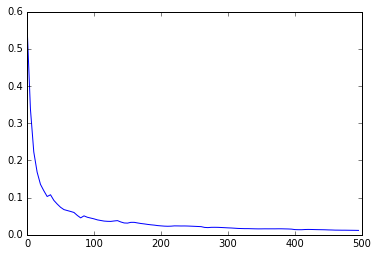

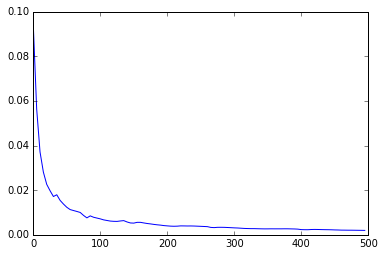

File = 1553957828_3_6
Game = kuhn_3_6
Total iterations = 500
Check every iteration = 5
Logged 100 out of 100.0 datapoints in 1310.3374547958374 seconds (aka 0.36398262633217704 hours)
Average duration of batch = 13.103374547958374 seconds (aka 0.0036398262633217707 hours)
Solved in 1310.7104647159576 seconds
Solved in 21.84517441193263 minutes
Solved in 0.36408624019887714 hours
Final utility = [-0.14072330349844406, -0.06340808915903375, 0.2041313926574787]
Social welfare = 8.881784197001252e-16
Average iterations per second = 0.38147250171559005


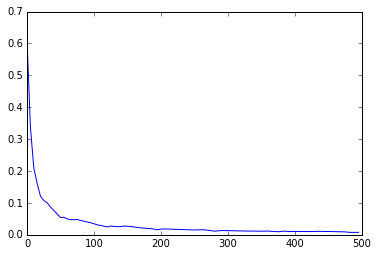

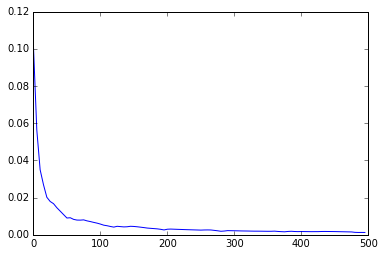

File = 1553778409_3_8
Game = kuhn_3_8
Total iterations = 100000
Check every iteration = 100
Logged 195 out of 1000.0 datapoints in 178428.0314192772 seconds (aka 49.56334206091033 hours)
Average duration of batch = 915.015545739883 seconds (aka 0.25417098492774526 hours)


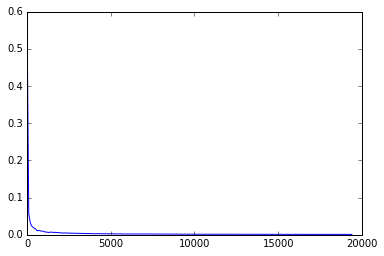

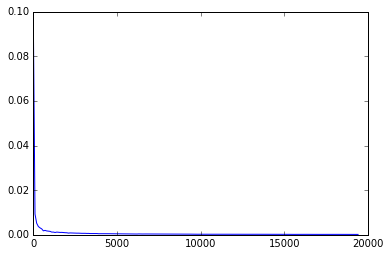

File = 1553778401_3_7
Game = kuhn_3_7
Total iterations = 100000
Check every iteration = 100
Logged 512 out of 1000.0 datapoints in 179627.48053073883 seconds (aka 49.896522369649674 hours)
Average duration of batch = 350.8349229115993 seconds (aka 0.09745414525322202 hours)


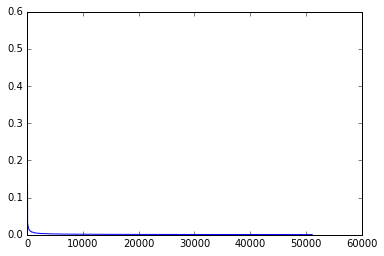

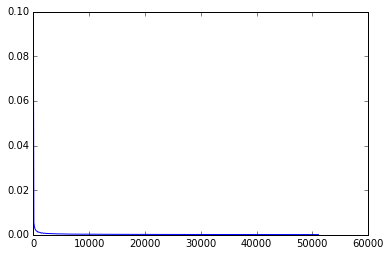

File = 1553957868_3_7
Game = kuhn_3_7
Total iterations = 500
Check every iteration = 5
Logged 100 out of 100.0 datapoints in 5305.299565315247 seconds (aka 1.4736943236986797 hours)
Average duration of batch = 53.052995653152465 seconds (aka 0.014736943236986795 hours)
Solved in 5305.764757871628 seconds
Solved in 88.4294126311938 minutes
Solved in 1.47382354385323 hours
Final utility = [0.019675242990144046, 0.04594605336193423, -0.06562129635207845]
Social welfare = -1.6653345369377348e-16
Average iterations per second = 0.09423712185094532


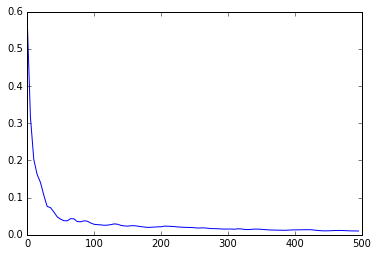

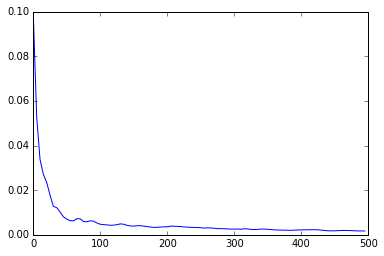

File = 1553957872_3_8
Game = kuhn_3_8
Total iterations = 500
Check every iteration = 5
Logged 100 out of 100.0 datapoints in 13586.712556123734 seconds (aka 3.7740868211454814 hours)
Average duration of batch = 135.86712556123734 seconds (aka 0.037740868211454816 hours)
Solved in 13587.401748418808 seconds
Solved in 226.45669580698012 minutes
Solved in 3.774278263449669 hours
Final utility = [0.01671177008218531, 0.033887014783187425, -0.05059878486537056]
Social welfare = 2.1788126858268697e-15
Average iterations per second = 0.03679879415195668


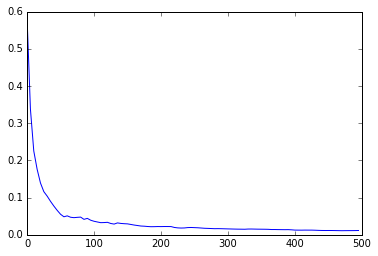

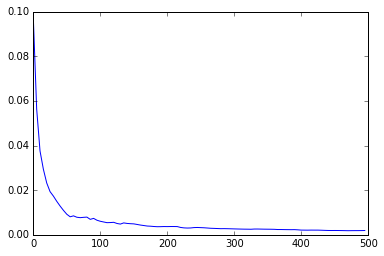

File = 1553957883_3_10
Game = kuhn_3_10
Total iterations = 500
Check every iteration = 5
Logged 100 out of 100.0 datapoints in 74469.23972225189 seconds (aka 20.68589992284775 hours)
Average duration of batch = 744.6923972225189 seconds (aka 0.20685899922847747 hours)
Solved in 74490.03030323982 seconds
Solved in 1241.5005050539971 minutes
Solved in 20.691675084233285 hours
Final utility = [0.011824321205830584, -0.11310671480008916, 0.10128239359426179]
Social welfare = 3.219646771412954e-15
Average iterations per second = 0.0067123076466013105


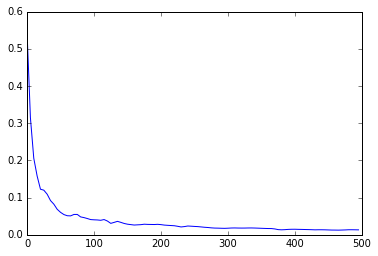

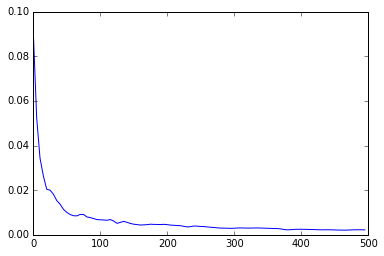

File = 1553778395_3_6
Game = kuhn_3_6
Total iterations = 100000
Check every iteration = 100
Logged 1000 out of 1000.0 datapoints in 163840.43873405457 seconds (aka 45.51123298168182 hours)
Average duration of batch = 163.84043873405457 seconds (aka 0.045511232981681825 hours)
Solved in 163895.6140244007 seconds
Solved in 2731.593567073345 minutes
Solved in 45.52655945122242 hours
Final utility = [-0.01673095417888386, -0.01673095417888269, 0.0334619083577648]
Social welfare = -1.7486012637846216e-15
Average iterations per second = 0.6101444544154307


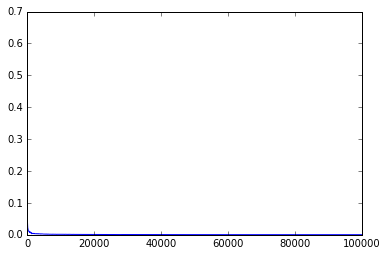

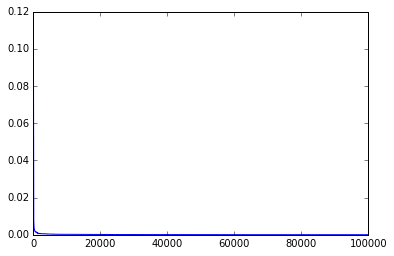

In [19]:
target_epsilons = [10, 5, 2, 1.5, 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0]
data_per_instance = {}

for name in file_names:
    analyze(name, target_epsilons, data_per_instance)

In [25]:
size_data = {
    'kuhn_3_6': (72, 147),
    'kuhn_3_7': (84, 171),
    'kuhn_3_8': (96, 195),
    'kuhn_3_9': (108, 219),
    'kuhn_3_10': (120, 243),
    
    'leduc_3_3_3': (684, 1371),
    'leduc_3_3_4': (1200, 2403),
    'leduc_3_3_5': (1860, 3723),
    'leduc_3_3_6': (2664, 5331),
    
    'goofspiel_3_3_accumulate': (194, 396),
    'goofspiel_3_3_discard_if_all': (194, 396),
    'goofspiel_3_3_discard_if_high': (194, 396),
    'goofspiel_3_3_discard_always': (194, 396),
    'goofspiel_3_4_accumulate': (48966, 98523),
    'goofspiel_3_4_discard_if_all': (48966, 98523),
    'goofspiel_3_4_discard_if_high': (48966, 98523),
    'goofspiel_3_4_discard_always': (48966, 98523),
    
    # Random sized are taken from specific dat files
    'random_2_5_2': (24, 46),
    'random_2_6_2': (52, 102),
    'random_2_7_2': (94, 186),
    'random_2_8_2': (186, 370),
    'random_2_9_2': (383, 764),
    'random_2_10_2': (776, 1550),
    'random_3_5_2': (29, 55),
    'random_3_6_2': (49, 95),
    'random_3_7_2': (100, 197),
    'random_3_8_2': (206, 409),
    'random_3_9_2': (378, 753),
    'random_3_10_2': (757, 1541),
}

In [26]:
def count_sequences(cfr_tree):
    all_nodes = reduce(lambda x, y: x + y.nodes, cfr_tree.information_sets.values(), [])
    all_leaves = list(filter(lambda n: n.isLeaf(), reduce(lambda x, y: x + y.children, all_nodes, [])))
    all_nodes = all_nodes + all_leaves
    
    count = 0

    for p in range(cfr_tree.numOfPlayers):
        Q_raw = list(filter(lambda q: q != {}, map(lambda n: n.base_node.getSequence(p), all_nodes)))
        Q = [{}] + [dict(t) for t in {tuple(d.items()) for d in Q_raw}]
        count += len(Q)
        
    return count

def count_infosets(cfr_tree):
    return len(cfr_tree.information_sets)

def get_size_data(par):
    name = parameters_to_string(par)
    if name not in size_data:
        if par['game'] == 'kuhn':
            cfr_tree = CFRTree(build_kuhn_tree(par['players'], par['rank']))
        elif par['game'] == 'leduc':
            cfr_tree = CFRTree(build_leduc_tree(par['players'], par['suits'], par['rank'], 
                                                par['betting_parameters']))
        elif par['game'] == 'goofspiel':
            # Tie solver is not needed to determine the size of the game
            cfr_tree = CFRTree(build_goofspiel_tree(par['players'], par['rank']))
        size_data[name] = (count_infosets(cfr_tree), count_sequences(cfr_tree))
        
    return size_data[name]

In [27]:
from IPython.display import HTML, display
import tabulate

In [30]:
table_text = [['Game', 'Inf.', 'Seq.', 'Delta'] + (list(map(lambda el: str(el) + '%', target_epsilons)))]
for (game, data) in sorted(data_per_instance.items()):
    par = data['parameters']
    
    size = get_size_data(par)
    
    line_text = [game, size[0], size[1]]
    line_text.append(delta_utility(par['game'], par['players'], par['rank'], par['betting_parameters']))
    line_text += list(map(lambda t: 'n/a' if t == -1 else str(t), data['time_to_target']))
    
    table_text.append(line_text)
    
    print(game + " done")

kuhn_3_10 done
kuhn_3_6 done
kuhn_3_6_ done
kuhn_3_7 done
kuhn_3_7_ done
kuhn_3_8 done
kuhn_3_8_ done
kuhn_3_9 done


In [31]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

Game,Inf.,Seq.,Delta,10%,5%,2%,1.5%,1%,0.5%,0.2%,0.1%,0.01%,0.005%,0.001%,0%
kuhn_3_10,120,243,6,327.51935,327.51935,327.51935,327.51935,327.51935,327.51935,327.51935,327.51935,9856.73274,26067.72938,n/a,n/a
kuhn_3_6,72,147,6,7.29175,7.29175,7.29175,7.29175,7.29175,7.29175,7.29175,31.95512,145.58629,308.11428,n/a,n/a
kuhn_3_6_,72,147,6,7.06997,7.06997,7.06997,7.06997,7.06997,7.06997,7.06997,112.15492,112.15492,218.98729,1025.01857,n/a
kuhn_3_7,84,171,6,20.26441,20.26441,20.26441,20.26441,20.26441,20.26441,20.26441,20.26441,315.47932,643.9992,4318.35328,n/a
kuhn_3_7_,84,171,6,23.619,23.619,23.619,23.619,23.619,23.619,23.619,23.619,463.07731,931.0293,n/a,n/a
kuhn_3_8,96,195,6,51.29098,51.29098,51.29098,51.29098,51.29098,51.29098,51.29098,51.29098,934.14292,2596.00571,18287.22738,n/a
kuhn_3_8_,96,195,6,64.96965,64.96965,64.96965,64.96965,64.96965,64.96965,64.96965,64.96965,1729.01424,4100.24956,n/a,n/a
kuhn_3_9,108,219,6,148.365,148.365,148.365,148.365,148.365,148.365,148.365,148.365,5187.49097,12451.09684,n/a,n/a


In [48]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

Game,Inf.,Seq.,Delta,10%,5%,2%,1.5%,1%,0.5%,0.2%,0.1%,0.01%,0%
kuhn_3_10,120,243,6,327.51935,327.51935,327.51935,327.51935,327.51935,327.51935,327.51935,327.51935,n/a,n/a
kuhn_3_6,72,147,6,7.29175,7.29175,7.29175,7.29175,7.29175,7.29175,7.29175,31.95512,145.58629,n/a
kuhn_3_7,84,171,6,23.619,23.619,23.619,23.619,23.619,23.619,23.619,23.619,463.07731,n/a
kuhn_3_8,96,195,6,64.96965,64.96965,64.96965,64.96965,64.96965,64.96965,64.96965,64.96965,1729.01424,n/a
kuhn_3_9,108,219,6,148.365,148.365,148.365,148.365,148.365,148.365,148.365,148.365,5187.49097,n/a


### Table for number of iterations instead of running time

In [61]:
table_text2 = [['Targets'] + (list(map(str, target_epsilons)))]
for (game, data) in sorted(data_per_instance.items()):
    line_text = [game] + list(map(lambda t: 'n/a' if t == -1 else str(t), data['iterations_to_target']))
    table_text2.append(line_text)

In [62]:
display(HTML(tabulate.tabulate(table_text2, tablefmt='html')))

Targets,10,5,2,1.5,1,0.5,0.2,0.1,0.01,0
kuhn_2_2,10,10,10,10,10,10,10,20,340,n/a
kuhn_2_3,10,10,10,10,10,10,10,30,1360,n/a
kuhn_2_4,10,10,10,10,10,10,10,40,2010,n/a
kuhn_2_5,10,10,10,10,10,10,10,40,2240,n/a
kuhn_2_6,10,10,10,10,10,10,10,20,2710,n/a
kuhn_2_7,10,10,10,10,10,10,10,20,3830,n/a
kuhn_2_8,10,10,10,10,10,10,10,10,5570,n/a
kuhn_3_3,10,10,10,10,10,10,10,40,350,n/a
kuhn_3_4,10,10,10,10,10,10,10,40,2230,n/a
kuhn_3_5,10,10,10,10,10,10,10,40,3300,n/a


## Time comparisons

In [52]:
def compare(files, xlims = None, ylims = None):
    for filename in files:
        file = open(filename, "r")
        data = json.load(file)
        file.close()

        print("File = " + filename)
        print("Game = " + parameters_to_string(data['parameters']))

        print("Total iterations = " + str(data['parameters']['number_iterations']))
        print("Check every iteration = " + str(data['parameters']['check_every_iteration']))

        durations = list(map(lambda el: el['duration'], data['data']))

        du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                       data['parameters']['betting_parameters'])

        iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
        epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
        percent_epsilons = list(map(lambda el: el / du, epsilons))
        cum_durations = [sum(durations[:i]) for i in range(len(durations))]

        plt.plot(cum_durations, percent_epsilons)
        
    plt.legend(["Result " + str(i+1) for i in range(len(files))])
    plt.xlabel("Time [s]")
    plt.ylabel("Epsilon [%]")
    if ylims != None:
        plt.ylim(ylims)
    if xlims != None:
        plt.xlim(xlims)
    plt.show()

File = results/remote/RCFR/kuhn/1553957872_3_8
Game = kuhn_3_8
Total iterations = 500
Check every iteration = 5
File = results/remote/kuhn_20190120/1547765102_3_8
Game = kuhn_3_8
Total iterations = 1000000
Check every iteration = 1000


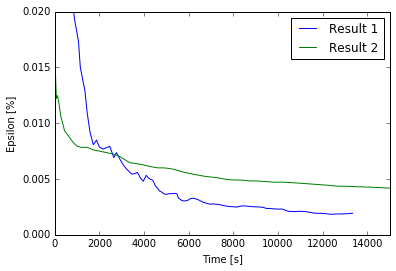

File = results/remote/RCFR/kuhn/1553957872_3_8
Game = kuhn_3_8
Total iterations = 500
Check every iteration = 5
File = results/remote/kuhn_short_20190121/1548008644_3_7
Game = kuhn_3_7
Total iterations = 10000
Check every iteration = 10


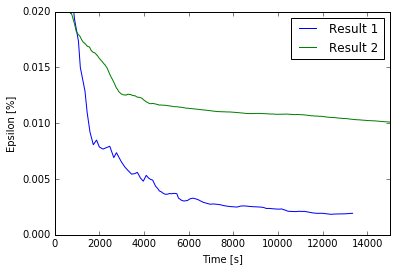

File = results/remote/RCFR/kuhn/1553957868_3_7
Game = kuhn_3_7
Total iterations = 500
Check every iteration = 5
File = results/remote/kuhn_20190120/1547765096_3_7
Game = kuhn_3_7
Total iterations = 1000000
Check every iteration = 1000


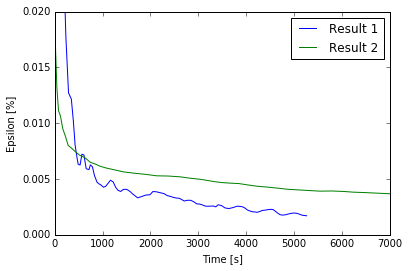

In [63]:
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/kuhn_20190120/1547765102_3_8'],
        xlims = (0, 15000), ylims = (0, 0.02))
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/kuhn_short_20190121/1548008644_3_7'],
        xlims = (0, 15000), ylims = (0, 0.02))
compare(['results/remote/RCFR/kuhn/1553957868_3_7', 'results/remote/kuhn_20190120/1547765096_3_7'],
        xlims = (0, 7000), ylims = (0, 0.02))

File = results/remote/RCFR/kuhn/1553957883_3_10
Game = kuhn_3_10
Total iterations = 500
Check every iteration = 5
File = results/remote/RCFR_notopt/kuhn/1554108461_3_10
Game = kuhn_3_10
Total iterations = 500
Check every iteration = 5


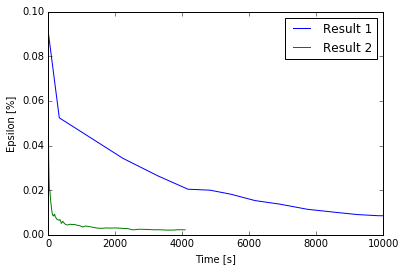

In [66]:
compare(['results/remote/RCFR/kuhn/1553957883_3_10', 'results/remote/RCFR_notopt/kuhn/1554108461_3_10'],
        xlims = (0, 10000))

File = results/remote/RCFR/kuhn/1553957872_3_8
Game = kuhn_3_8
Total iterations = 500
Check every iteration = 5
File = results/remote/RCFR_notopt/kuhn/1554108461_3_8
Game = kuhn_3_8
Total iterations = 500
Check every iteration = 5
File = results/remote/kuhn_20190120/1547765102_3_8
Game = kuhn_3_8
Total iterations = 1000000
Check every iteration = 1000


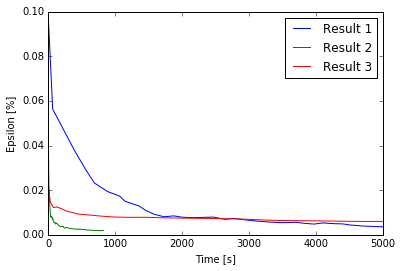

In [68]:
compare(['results/remote/RCFR/kuhn/1553957872_3_8', 'results/remote/RCFR_notopt/kuhn/1554108461_3_8',
         'results/remote/kuhn_20190120/1547765102_3_8'],
        xlims = (0, 5000))

---

## SCFR/CFR/CFR+ comparisons

In [17]:
import numpy as np

In [18]:
def compare_algorithms(filename, filename_cfr, filename_cfr_plus, cumsum_durations = False):
    file = open(filename, "r")
    data = json.load(file)
    file.close()

    file_cfr = open(filename_cfr, "r")
    data_cfr = json.load(file_cfr)
    file_cfr.close()

    file_cfr_plus = open(filename_cfr_plus, "r")
    data_cfr_plus = json.load(file_cfr_plus)
    file_cfr_plus.close()    

    durations = list(map(lambda el: el['duration'], data['data']))
    durations_cfr = list(map(lambda el: el['duration'], data_cfr['data']))
    durations_cfr_plus = list(map(lambda el: el['duration'], data_cfr_plus['data']))

    du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'])
    du_cfr = delta_utility(data_cfr['parameters']['game'], data_cfr['parameters']['players'], 
                           data_cfr['parameters']['rank'], data_cfr['parameters']['betting_parameters'])
    du_cfr_plus = delta_utility(data_cfr_plus['parameters']['game'], data_cfr_plus['parameters']['players'], 
                           data_cfr_plus['parameters']['rank'], data_cfr_plus['parameters']['betting_parameters'])

    iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
    epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
    percent_epsilons = list(map(lambda el: el / du, epsilons))
    iteration_counts_cfr = list(map(lambda el: el['iteration_number'], data_cfr['data']))
    epsilons_cfr = list(map(lambda el: max(0, -min(el['epsilon'])), data_cfr['data']))
    percent_epsilons_cfr = list(map(lambda el: el / du_cfr, epsilons_cfr))
    iteration_counts_cfr_plus = list(map(lambda el: el['iteration_number'], data_cfr_plus['data']))
    epsilons_cfr_plus = list(map(lambda el: max(0, -min(el['epsilon'])), data_cfr_plus['data']))
    percent_epsilons_cfr_plus = list(map(lambda el: el / du_cfr_plus, epsilons_cfr_plus))
    utilities = list(map(lambda el: el['utility'], data['data']))
    utilities_cfr = list(map(lambda el: el['utility'], data_cfr['data']))
    utilities_cfr_plus = list(map(lambda el: el['utility'], data_cfr_plus['data']))

    print(data['parameters'])
    if 'total_duration' in data:
        print("Duration = " + str(data['total_duration']) + " seconds")
        print("Utility = " + str(data['utility']))
        print("Social welfare = " + str(sum(data['utility'])))
        print("Max delta utility = " + str(max(data['utility']) - min(data['utility'])))
    else:
        print("--- Computation was stopped before the end ---")
        print("Duration = " + str(sum(durations)) + " seconds")
        print("Last logged utility = " + str(utilities[len(utilities)-1]))
        print("Social welfare = " + str(sum(utilities[len(utilities)-1])))
        print("Max delta utility = " + str(max(utilities[len(utilities)-1]) - min(utilities[len(utilities)-1])))
    print('')
    print(data_cfr['parameters'])
    if 'total_duration' in data_cfr:
        print("Duration = " + str(data_cfr['total_duration']) + " seconds")
        print("Utility = " + str(data_cfr['utility']))
        print("Social welfare = " + str(sum(data_cfr['utility'])))
        print("Max delta utility = " + str(max(data_cfr['utility']) - min(data_cfr['utility'])))
    else:
        print("--- Computation was stopped before the end ---")
        print("Duration = " + str(sum(durations_cfr)) + " seconds")
        print("Last logged utility = " + str(utilities_cfr[len(utilities_cfr)-1]))
        print("Social welfare = " + str(sum(utilities_cfr[len(utilities_cfr)-1])))
        print("Max delta utility = " + str(max(utilities_cfr[len(utilities_cfr)-1]) - \
                                           min(utilities_cfr[len(utilities_cfr)-1])))
    print('')
    print(data_cfr_plus['parameters'])
    if 'total_duration' in data_cfr_plus:
        print("Duration = " + str(data_cfr_plus['total_duration']) + " seconds")
        print("Utility = " + str(data_cfr_plus['utility']))
        print("Social welfare = " + str(sum(data_cfr_plus['utility'])))
        print("Max delta utility = " + str(max(data_cfr_plus['utility']) - min(data_cfr_plus['utility'])))
    else:
        print("--- Computation was stopped before the end ---")
        print("Duration = " + str(sum(durations_cfr_plus)) + " seconds")
        print("Last logged utility = " + str(utilities_cfr_plus[len(utilities_cfr_plus)-1]))
        print("Social welfare = " + str(sum(utilities_cfr_plus[len(utilities_cfr_plus)-1])))
        print("Max delta utility = " + str(max(utilities_cfr_plus[len(utilities_cfr_plus)-1]) - \
                                           min(utilities_cfr_plus[len(utilities_cfr_plus)-1])))
    print('')

    #plt.plot(iteration_counts, epsilons)
    #plt.plot(iteration_counts_cfr, epsilons_cfr)
    #plt.plot(iteration_counts_cfr_plus, epsilons_cfr_plus)
    #plt.show()
    
    plt.plot(iteration_counts, percent_epsilons)
    plt.plot(iteration_counts_cfr, percent_epsilons_cfr)
    plt.plot(iteration_counts_cfr_plus, percent_epsilons_cfr_plus)
    plt.legend(['scfr','cfr', 'cfr+'])
    plt.show()
    
    plt.plot(np.cumsum(durations), percent_epsilons)
    plt.plot(np.cumsum(durations_cfr) if cumsum_durations else durations_cfr, percent_epsilons_cfr)
    plt.plot(np.cumsum(durations_cfr_plus) if cumsum_durations else durations_cfr_plus, percent_epsilons_cfr_plus)
    plt.legend(['scfr','cfr', 'cfr+'])
    plt.show()

{'check_every_iteration': 10, 'rank': 4, 'game': 'goofspiel', 'algorithm': 'scfr', 'results': 'results/cfr_comparisons/', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'accumulate', 'bootstrap_iterations': 0, 'number_iterations': 2000, 'logfile': 'results/log.log', 'players': 3}
Duration = 9728.739486932755 seconds
Utility = [3.6874375000000006, 3.083604166666662, 3.124270833333335]
Social welfare = 9.895312499999998
Max delta utility = 0.6038333333333386

{'check_every_iteration': 10, 'rank': 4, 'game': 'goofspiel', 'algorithm': 'cfr', 'results': 'results/cfr_comparisons/', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'accumulate', 'bootstrap_iterations': 0, 'number_iterations': 2000, 'logfile': 'results/log.log', 'players': 3}
Duration = 28134.846471071243 seconds
Utility = [3.046943473865055, 3.3072036034816734, 3.645852922653271]
Social welfare = 10.0
Max delta utility = 0.5989094487882163

{'check_every_itera

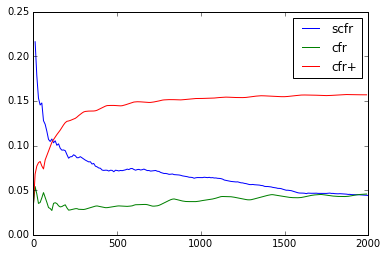

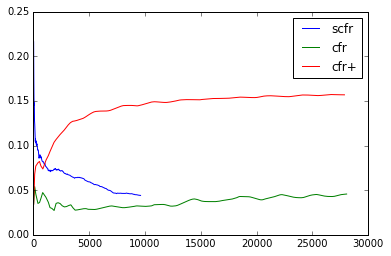

In [19]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_scfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_accumulate')

{'check_every_iteration': 100, 'rank': 3, 'players': 3, 'algorithm': 'scfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'accumulate', 'bootstrap_iterations': 0, 'betting_parameters': [2, 4], 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'game': 'goofspiel'}
Duration = 1291.0722110271454 seconds
Utility = [1.9914666666664902, 1.973966666666493, 2.0316166666664865]
Social welfare = 5.99704999999947
Max delta utility = 0.05764999999999354

{'check_every_iteration': 100, 'rank': 3, 'game': 'goofspiel', 'algorithm': 'cfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'accumulate', 'iset_probability': 1, 'bootstrap_iterations': 0, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'players': 3}
Duration = 1323.0091471672058 seconds
Utility = [2.0, 2.0, 1.99999

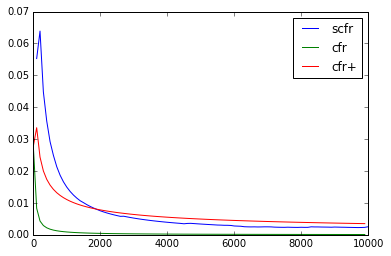

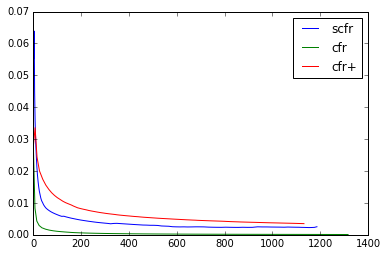

In [20]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_accumulate',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_accumulate',
                   cumsum_durations = True)

{'check_every_iteration': 100, 'rank': 3, 'players': 3, 'algorithm': 'scfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_if_all', 'iset_probability': 1, 'bootstrap_iterations': 0, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'game': 'goofspiel'}
Duration = 1129.8483457565308 seconds
Utility = [2.048383333333159, 1.9809499999998605, 1.9540333333331943]
Social welfare = 5.983366666666214
Max delta utility = 0.09434999999996485

{'check_every_iteration': 100, 'rank': 3, 'players': 3, 'algorithm': 'cfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_if_all', 'betting_parameters': [2, 4], 'number_iterations': 10000, 'bootstrap_iterations': 0, 'branching_factor': 2, 'logfile': 'results/log.log', 'game': 'goofspiel'}
Duration = 1124.489798784256 seconds
Utility = [1.5, 1.5,

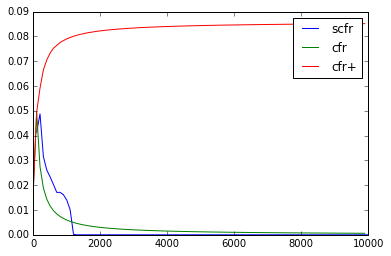

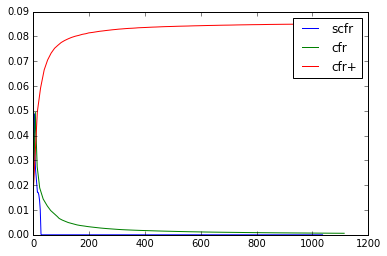

In [21]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_discard_if_all',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_discard_if_all', 
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_discard_if_all',
                   cumsum_durations = True)

{'betting_parameters': [2, 4], 'check_every_iteration': 100, 'rank': 3, 'game': 'goofspiel', 'algorithm': 'scfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_if_high', 'bootstrap_iterations': 0, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'players': 3}
Duration = 1081.6270053386688 seconds
Utility = [2.1362333333334464, 1.4186666666667425, 1.5121666666668703]
Social welfare = 5.06706666666706
Max delta utility = 0.717566666666704

{'check_every_iteration': 100, 'rank': 3, 'players': 3, 'algorithm': 'cfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_if_high', 'betting_parameters': [2, 4], 'number_iterations': 10000, 'bootstrap_iterations': 0, 'branching_factor': 2, 'logfile': 'results/log.log', 'game': 'goofspiel'}
Duration = 1185.5137658119202 seconds
Utility = [2.5, 1.5

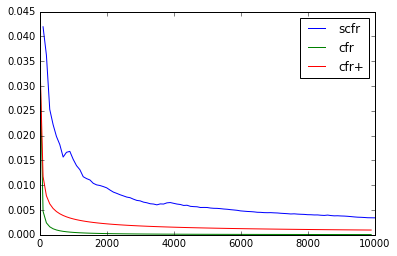

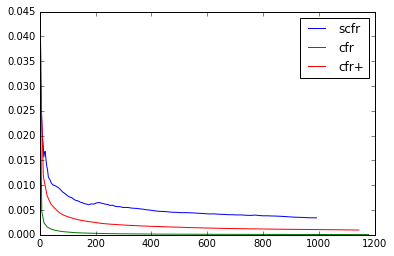

In [22]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_discard_if_high',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_discard_if_high',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_discard_if_high',
                   cumsum_durations = True)

{'check_every_iteration': 100, 'rank': 3, 'game': 'goofspiel', 'algorithm': 'scfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_always', 'bootstrap_iterations': 0, 'betting_parameters': [2, 4], 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'players': 3}
Duration = 1279.5281336307526 seconds
Utility = [0.9861833333332528, 0.9657666666665877, 0.9828999999999191]
Social welfare = 2.9348499999997597
Max delta utility = 0.020416666666665084

{'check_every_iteration': 100, 'rank': 3, 'game': 'goofspiel', 'algorithm': 'cfr', 'depth': 4, 'results': 'results/cfr_comparisons/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_always', 'betting_parameters': [2, 4], 'number_iterations': 10000, 'bootstrap_iterations': 0, 'branching_factor': 2, 'logfile': 'results/log.log', 'players': 3}
Duration = 1325.0582342147827 seconds
Utility = [2.083

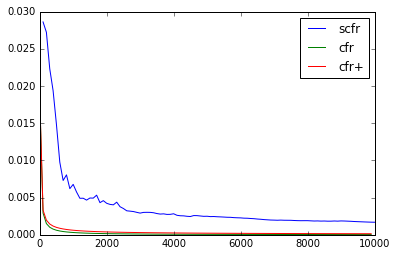

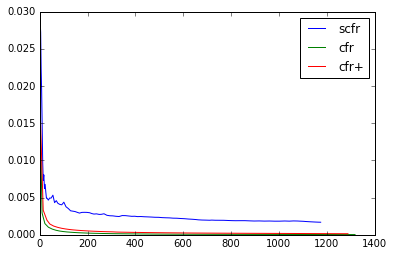

In [23]:
compare_algorithms('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_scfr_discard_always',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_discard_always',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_3_cfr_plus_discard_always',
                   cumsum_durations = True)

{'check_every_iteration': 100, 'bound_joint_size': None, 'game': 'goofspiel', 'algorithm': 'scfr', 'depth': 4, 'results': 'results/lg/', 'betting_parameters': [2, 4], 'bootstrap_iterations': 0, 'suits': 3, 'tie_solver': 'discard_always', 'rank': 4, 'iset_probability': 1, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'players': 3}
Duration = 20157.70127272606 seconds
Utility = [2.489704166666701, 2.21930833333333, 2.0421333333333087]
Social welfare = 6.751145833333339
Max delta utility = 0.4475708333333923

{'check_every_iteration': 100, 'rank': 4, 'game': 'goofspiel', 'algorithm': 'cfr', 'depth': 4, 'results': 'results/', 'iset_probability': 1, 'bootstrap_iterations': 0, 'suits': 3, 'tie_solver': 'discard_always', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': '1548152888log.log', 'players': 3}
--- Computation was stopped before the end ---
Duration = 26357.277654647827 seconds
Las

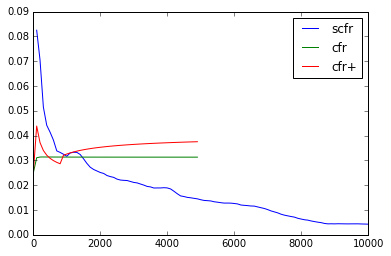

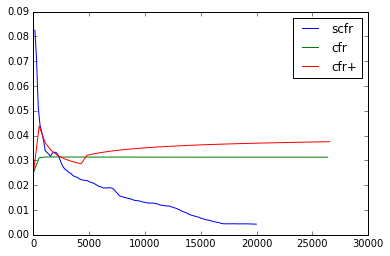

In [24]:
compare_algorithms('results/remote/goofspiel_long_20180122/1548105233_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_always_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_always_ALBO',
                   cumsum_durations = True)

{'check_every_iteration': 100, 'rank': 4, 'players': 3, 'algorithm': 'scfr', 'depth': 4, 'results': 'results/lg/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_if_high', 'bootstrap_iterations': 0, 'betting_parameters': [2, 4], 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'game': 'goofspiel'}
Duration = 20898.217500686646 seconds
Utility = [3.054133333333313, 3.0469874999998647, 2.849354166666654]
Social welfare = 8.950474999999832
Max delta utility = 0.20477916666665896

{'check_every_iteration': 100, 'rank': 4, 'game': 'goofspiel', 'algorithm': 'cfr', 'depth': 4, 'results': 'results/', 'iset_probability': 1, 'bootstrap_iterations': 0, 'suits': 3, 'tie_solver': 'discard_if_high', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': '1548152878log.log', 'players': 3}
--- Computation was stopped before the end ---
Duration = 26614.76695394516 seconds

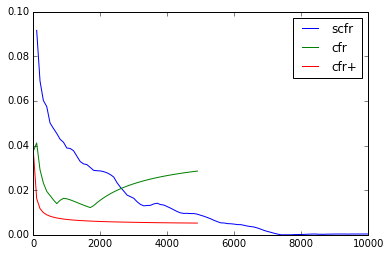

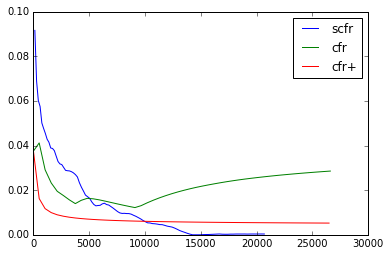

In [25]:
compare_algorithms('results/remote/goofspiel_long_20180122/1548105230_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_high_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_high_ALBO',
                   cumsum_durations = True)

{'check_every_iteration': 100, 'rank': 4, 'game': 'goofspiel', 'algorithm': 'scfr', 'depth': 4, 'results': 'results/lg/', 'iset_probability': 1, 'bound_joint_size': None, 'suits': 3, 'tie_solver': 'discard_if_all', 'bootstrap_iterations': 0, 'betting_parameters': [2, 4], 'number_iterations': 10000, 'branching_factor': 2, 'logfile': 'results/log.log', 'players': 3}
Duration = 20617.491241455078 seconds
Utility = [3.6233583333333352, 3.2238416666666496, 3.0022208333333453]
Social welfare = 9.84942083333333
Max delta utility = 0.6211374999999899

{'check_every_iteration': 100, 'rank': 4, 'game': 'goofspiel', 'algorithm': 'cfr', 'depth': 4, 'results': 'results/', 'iset_probability': 1, 'bootstrap_iterations': 0, 'suits': 3, 'tie_solver': 'discard_if_all', 'betting_parameters': [2, 4], 'bound_joint_size': None, 'number_iterations': 10000, 'branching_factor': 2, 'logfile': '1548152845log.log', 'players': 3}
--- Computation was stopped before the end ---
Duration = 26220.10195851326 seconds
L

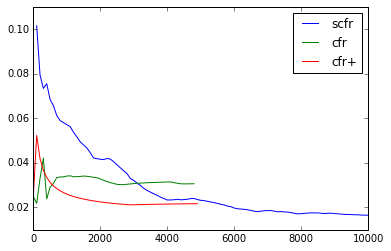

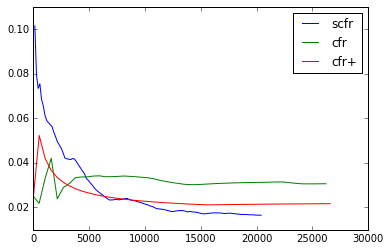

In [26]:
compare_algorithms('results/remote/goofspiel_long_20180122/1548105224_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_all_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_all_ALBO',
                   cumsum_durations = True)

## Data to CSV for tikz

In [27]:
f1 = open('results/remote/goofspiel_long_20180122/1548105233_3_4', 'r')
f2 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_always_ALBO', 'r')
f3 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_always_ALBO', 'r')

f4 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_scfr_accumulate', 'r')
f5 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_accumulate', 'r')
f6 = open('results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_accumulate', 'r')

data1 = json.load(f1)
data2 = json.load(f2)
data3 = json.load(f3)

data4 = json.load(f4)
data5 = json.load(f5)
data6 = json.load(f6)

durations1 = list(map(lambda el: el['duration'], data1['data']))
durations2 = list(map(lambda el: el['duration'], data2['data']))
durations3 = list(map(lambda el: el['duration'], data3['data']))

durations4 = list(map(lambda el: el['duration'], data4['data']))
durations5 = list(map(lambda el: el['duration'], data5['data']))
durations6 = list(map(lambda el: el['duration'], data6['data']))

du = delta_utility('goofspiel', 3, 4)

with open("cfr_comparison_3_4_discard_always_scfr.csv", 'w') as o:
    o.write('iteration, epsilon, t\n')
    
    for i in range(len(data1['data'])):
        d = data1['data'][i]
        o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon']) / du) + ', ' + \
                str(sum(durations1[:i+1])) + "\n")
        
with open("cfr_comparison_3_4_discard_always_cfr.csv", 'w') as o:
    o.write('iteration, epsilon, t\n')
    
    for i in range(len(data2['data'])):
        d = data2['data'][i]
        o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon']) / du) + ', ' + \
                str(sum(durations2[:i+1])) + "\n")
        
with open("cfr_comparison_3_4_discard_always_cfr_plus.csv", 'w') as o:
    o.write('iteration, epsilon, t\n')
    
    for i in range(len(data3['data'])):
        d = data3['data'][i]
        o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon']) / du) + ', ' + \
                str(sum(durations3[:i+1])) + "\n")

with open("cfr_comparison_3_4_accumulate.csv", 'w') as o:
    o.write('iteration, scfr, cfr, cfr+\n')
    
    iterations = list(map(lambda el: el['iteration_number'], data4['data']))
    epsilons4 = list(map(lambda el: -min(el['epsilon']) / du, data4['data']))
    epsilons5 = list(map(lambda el: -min(el['epsilon']) / du, data5['data']))
    epsilons6 = list(map(lambda el: -min(el['epsilon']) / du, data6['data']))
    
    for (it, s, c, cp) in zip(iterations, epsilons4, epsilons5, epsilons6):
        o.write(str(it) + ', ' + str(s) + ', ' + str(c) + ', ' + str(cp) + '\n')
        
f1.close()
f2.close()
f3.close()

f4.close()
f5.close()
f6.close()

In [28]:
icml_data_folder  = "../../../../Dropbox/Honours Programme/Shared Material/ICML-19/imgs/data/"

In [29]:
def print_csv(name1, name2, name3):
    f1 = open(name1, 'r')
    f2 = open(name2, 'r')
    f3 = open(name3, 'r')

    data1 = json.load(f1)
    data2 = json.load(f2)
    data3 = json.load(f3)

    durations1 = list(map(lambda el: el['duration'], data1['data']))
    durations2 = list(map(lambda el: el['duration'], data2['data']))
    durations3 = list(map(lambda el: el['duration'], data3['data']))

    du = delta_utility('goofspiel', 3, 4)

    shortest_run = min(sum(durations1), sum(durations2), sum(durations3))
    
    ts = data1['parameters']['tie_solver']

    with open(icml_data_folder + "cfr_comparison_3_4_" + ts + "_scfr.csv", 'w') as o:
        o.write('iteration, epsilon, t\n')

        for i in range(len(data1['data'])):
            if sum(durations1[:i+1]) > shortest_run:
                break

            d = data1['data'][i]
            o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon'] + [0]) / du) + ', ' + \
                    str(sum(durations1[:i+1])) + "\n")

    with open(icml_data_folder + "cfr_comparison_3_4_" + ts + "_cfr.csv", 'w') as o:
        o.write('iteration, epsilon, t\n')

        for i in range(len(data2['data'])):
            if sum(durations2[:i+1]) > shortest_run:
                break

            d = data2['data'][i]
            o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon'] + [0]) / du) + ', ' + \
                    str(sum(durations2[:i+1])) + "\n")

    with open(icml_data_folder + "cfr_comparison_3_4_" + ts + "_cfr_plus.csv", 'w') as o:
        o.write('iteration, epsilon, t\n')

        for i in range(len(data3['data'])):
            if sum(durations3[:i+1]) > shortest_run:
                break

            d = data3['data'][i]
            o.write(str(d['iteration_number']) + ', ' + str(-min(d['epsilon'] + [0]) / du) + ', ' + \
                    str(sum(durations3[:i+1])) + "\n")

    f1.close()
    f2.close()
    f3.close()

In [30]:
print_csv('results/remote/goofspiel_long_20180122/1548105233_3_4',
          'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_always_ALBO',
          'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_always_ALBO')

In [31]:
print_csv('results/remote/goofspiel_long_20180122/1548105230_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_high_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_high_ALBO')

In [32]:
print_csv('results/remote/goofspiel_long_20180122/1548105224_3_4',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_discard_if_all_ALBO',
                   'results/remote/goofspiel_cfr_comparisons_20190122/goofspiel_3_4_cfr_plus_discard_if_all_ALBO')